## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/PhysioNet/')

Mounted at /content/drive


## Pull data from PhysioNet

In [ ]:
!gsutil -m cp -r gs://nsrdb-1.0.0.physionet.org ./

In [ ]:
!pip install wfdb

import wfdb
from wfdb import processing

import torch
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt

In [ ]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Visualise Data

In [ ]:
# Demo 5 - Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord('mitbih_normal_sinus/16265', sampto = 3000)
annotation = wfdb.rdann('mitbih_normal_sinus/16265', 'atr', sampto = 3000)

print(record.sig_name)
print(record.sig_len)
print(record.units)

sig_name = [str(s) for s in record.sig_name]
sig_units = [str(s) for s in record.units]
record_name = 'Record: %s' % record.record_name
ylabel = ['/'.join(pair) for pair in zip(sig_name, sig_units)]

print(annotation.chan)
print(ylabel)

print(len(ylabel))

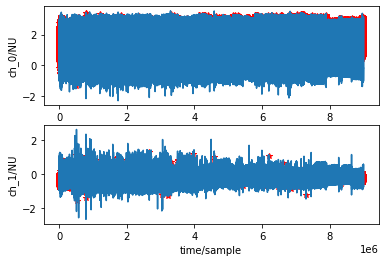

In [ ]:
end = 9000000
record = wfdb.rdrecord('mitbih_normal_sinus/16265', sampto=end)
ann = wfdb.rdann('mitbih_normal_sinus/16265', 'atr',sampto=end)

wfdb.plot_items(signal=record.p_signal,
                ann_samp=[ann.sample, ann.sample])

### Process NSR Data

Resample from original Fs of 128Hz to 100Hz

In [ ]:
new_signal = processing.resample_multichan(record.p_signal, ann, fs=128, fs_target=100, resamp_ann_chan=0)

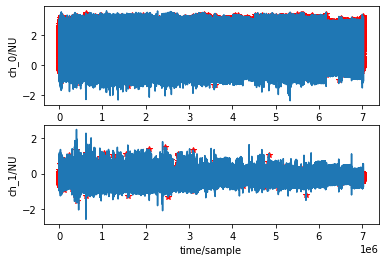

In [ ]:
wfdb.plot_items(signal=new_signal[0],
                ann_samp=[new_signal[1].sample, new_signal[1].sample])

Normalise Data between 0 and 1

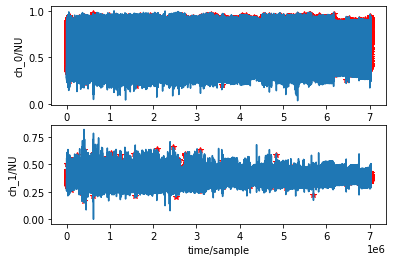

In [ ]:
ds_signal = processing.normalize_bound(new_signal[0], lb=0, ub=1)

wfdb.plot_items(signal=ds_signal,
                ann_samp=[new_signal[1].sample, new_signal[1].sample])

## R-peak detection

In [ ]:
xqrs = processing.XQRS(sig=ds_signal[:,0], fs=100)
xqrs.detect()

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


In [ ]:
print(xqrs.qrs_inds)
print(len(xqrs.qrs_inds)//3)

[     36     103     157 ... 7030990 7031082 7031194]
30201


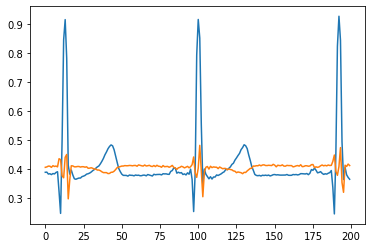

In [ ]:
plt.plot(ds_signal[7030990-100:7030990+100,0])
plt.plot(ds_signal[7030990-100:7030990+100,1])

Format Data into 2 ECG leads

In [ ]:
ECG_1 = []
ECG_2 = []

for i in range(6, len(xqrs.qrs_inds[:-6]), 3):
    ECG_1.append(ds_signal[xqrs.qrs_inds[i]-250 :xqrs.qrs_inds[i]+250, 0])
    ECG_2.append(ds_signal[xqrs.qrs_inds[i]-250 :xqrs.qrs_inds[i]+250, 1])

In [ ]:
print(len(ECG_1))
print(len(ECG_2))

30197
30197


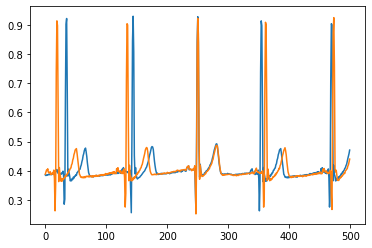

In [ ]:
for i in range(30195,30197):
  plt.plot(ECG_1[i])

## Save Data at `.pt`

In [ ]:
mv_data = torch.stack((Variable(Tensor(ECG_1)),Variable(Tensor(ECG_2))))
mv_data = mv_data.permute(1, 2, 0)
print('ECG_Shape:' +str(mv_data.shape))

torch.save(mv_data, '/content/drive/My Drive/MV_GAN_Journal/ecg_mit_nsnr.pt')

ECG_Shape:torch.Size([30197, 500, 2])
